# Flight Delay Prediction from DDS

Mục tiêu:
- Dự đoán chuyến bay có bị trễ hay không (Classification)
- Dự đoán số phút trễ (Regression)
- Phân nhóm hành vi trễ (Clustering)

Nguồn dữ liệu: DDS

### 1. Import thư viện

In [80]:
import numpy as np
import pandas as pd
import pyodbc
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve, mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.cluster import KMeans

### 2. Cấu hình đường dẫn & kết nối DB

In [81]:
OUT_DIR = Path(r"C:\Users\HP\BI-Project\data mining")
OUT_DIR.mkdir(parents=True, exist_ok=True)

SERVER = "localhost"
DATABASE = "Project_DDS_DB"

CONN_STR = (
    "DRIVER={ODBC Driver 17 for SQL Server};"
    "SERVER=localhost;"
    "DATABASE=Project_DDS_DB;"
    "Trusted_Connection=yes;"
)

### 3. SQL query lấy dữ liệu từ DDS

In [82]:
QUERY = """
SELECT
    f.Flight_ID,
    al.Airline_Name,
    ao.IATA_Code AS Origin_Airport,
    ad.IATA_Code AS Dest_Airport,

    d.[Month],
    d.Day_of_week,
    d.Is_Weekend,
    t.[Hour] AS Depart_Hour,

    f.Total_depart_delay,
    f.Total_arrive_delay,
    f.Air_system_delay,
    f.Weather_delay,
    f.Late_aircraft_delay,
    f.Airline_delay,
    f.Security_delay,

    f.Diverted_Flag,
    f.Canceled_Flag,

    CASE 
        WHEN ISNULL(f.Canceled_Flag,0) = 0
         AND ISNULL(f.Diverted_Flag,0) = 0
         AND ISNULL(f.Total_depart_delay,0) > 15
        THEN 1
        ELSE 0
    END AS Delay_Flag

FROM Fact_Flight f
JOIN Dim_Airline al ON f.Airline_ID = al.Airline_ID
JOIN Dim_Airport ao ON f.Origin_Airport_ID = ao.Airport_ID
JOIN Dim_Airport ad ON f.Dest_Airport_ID = ad.Airport_ID
JOIN Dim_Date d ON f.Depart_Date_ID = d.Date_ID
JOIN Dim_Time t ON f.Depart_Time_ID = t.Time_ID
"""

### 4. Load dữ liệu từ SQL Server

In [83]:
with pyodbc.connect(CONN_STR) as conn:
    df = pd.read_sql(QUERY, conn)

# Clean text columns
for c in ["Airline_Name", "Origin_Airport", "Dest_Airport"]:
    df[c] = df[c].astype(str).str.strip()

df.head()

,Flight_ID,Airline_Name,Origin_Airport,Dest_Airport,Month,Day_of_week,Is_Weekend,Depart_Hour,Total_depart_delay,Total_arrive_delay,Air_system_delay,Weather_delay,Late_aircraft_delay,Airline_delay,Security_delay,Diverted_Flag,Canceled_Flag,Delay_Flag
0,1,Spirit Air Lines,ORD,LGA,1,5,False,5,-9,27,27,0,0,0,0,False,False,0
1,2,American Airlines Inc.,DFW,LGA,1,5,False,6,-6,-5,0,0,0,0,0,False,False,0
2,3,American Airlines Inc.,LGA,DFW,1,5,False,6,0,0,0,0,0,0,0,False,True,0
3,4,Atlantic Southeast Airlines,CLT,ORD,1,5,False,6,-1,18,18,0,0,0,0,False,False,0
4,5,US Airways Inc.,EWR,CLT,1,5,False,6,6,15,9,0,0,6,0,False,False,0


### 5. Chuẩn bị feature

In [84]:
cat_cols = ["Airline_Name", "Origin_Airport", "Dest_Airport", "Day_of_week"]

num_cols = [
    "Month", "Is_Weekend", "Depart_Hour",
    "Weather_delay", "Air_system_delay", "Late_aircraft_delay",
    "Airline_delay", "Security_delay",
    "Total_arrive_delay",
    "Canceled_Flag", "Diverted_Flag"
]

for c in num_cols + ["Total_depart_delay"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=cat_cols + ["Delay_Flag"])
df["Delay_Flag"] = df["Delay_Flag"].astype(int)

df.shape

(105244, 18)

Tập dữ liệu sau khi trích xuất từ DDS gồm 105.244 bản ghi, mỗi bản ghi tương ứng với một chuyến bay và bao gồm 18 thuộc tính mô tả đặc điểm và nguyên nhân trễ chuyến bay.

### 6. Classification: RandomForest (trễ / không trễ)

In [85]:
X_cls = df[cat_cols + num_cols].copy()
y_cls = df["Delay_Flag"]

X_train, X_test, y_train, y_test = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls
)

cls_preprocess = ColumnTransformer(
    transformers=[
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median"))
        ]), num_cols)
    ]
)

rf_clf = Pipeline([
    ("prep", cls_preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=400,
        random_state=42,
        class_weight="balanced_subsample",
        n_jobs=-1
    ))
])

rf_clf.fit(X_train, y_train)

proba = rf_clf.predict_proba(X_test)[:, 1]
pred_05 = (proba >= 0.5).astype(int)

print("ROC-AUC:", roc_auc_score(y_test, proba))
print("Confusion matrix @0.5:\n", confusion_matrix(y_test, pred_05))
print(classification_report(y_test, pred_05))


# Tune threshold (F1)
prec, rec, thr = precision_recall_curve(y_test, proba)
thr = np.append(thr, 1.0)

f1 = 2 * (prec * rec) / (prec + rec + 1e-9)
best_idx = np.argmax(f1)
best_threshold = thr[best_idx]

print("Best threshold:", best_threshold)

clf_model_path = OUT_DIR / "rf_delay_classifier_from_dds.joblib"
joblib.dump(rf_clf, clf_model_path)

proba_all = rf_clf.predict_proba(X_cls)[:, 1]
pred_all = (proba_all >= best_threshold).astype(int)

scored_cls = df.copy()
scored_cls["Delay_Probability"] = proba_all
scored_cls["Delay_Pred"] = pred_all

OUT_DIR = Path("./dds_flight_delay_output")
OUT_DIR.mkdir(parents=True, exist_ok=True)
export_cls = OUT_DIR / "DDS_Flight_Delay_Scored_Classification.csv"
scored_cls.to_csv(export_cls, index=False)

ROC-AUC: 0.9686552185829252
Confusion matrix @0.5:
 [[16547   242]
 [  889  3371]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     16789
           1       0.93      0.79      0.86      4260

    accuracy                           0.95     21049
   macro avg       0.94      0.89      0.91     21049
weighted avg       0.95      0.95      0.94     21049

Best threshold: 0.530790690154376


### **Kết quả đánh giá mô hình phân loại chuyến bay bị trễ**

**ROC-AUC = 0.9687**

ROC-AUC (Receiver Operating Characteristic – Area Under Curve) đo lường khả năng mô hình phân biệt giữa hai lớp chuyến bay bị trễ và không bị trễ.  
Giá trị ROC-AUC càng gần 1 thì mô hình phân biệt càng tốt.

Với ROC-AUC ≈ 0.97, mô hình có khả năng phân biệt rất cao. Điều này có nghĩa là nếu chọn ngẫu nhiên một chuyến bay bị trễ và một chuyến bay không trễ, thì khoảng 96.9% trường hợp mô hình sẽ gán xác suất trễ cao hơn cho chuyến bay thực sự bị trễ.

**Confusion Matrix (ngưỡng phân loại = 0.5)**

| Thực tế \\ Dự đoán | Không trễ | Trễ |
|-------------------|----------|-----|
| **Không trễ** | 16.547 | 242 |
| **Trễ** | 889 | 3.371 |

- 16.547 chuyến bay không trễ và được mô hình dự đoán đúng.  
- 3.371 chuyến bay bị trễ và được mô hình phát hiện đúng.  
- 242 chuyến bay không trễ nhưng bị dự đoán nhầm là trễ (*false positive*).  
- 889 chuyến bay bị trễ nhưng mô hình không phát hiện được (*false negative*).

Confusion matrix cho thấy mô hình dự đoán chính xác phần lớn các chuyến bay, tuy nhiên vẫn còn một số chuyến bay bị trễ chưa được nhận diện.

**Precision, Recall và F1-score**

| Lớp | Precision | Recall | F1-score | Support |
|----|-----------|--------|----------|---------|
| **0 (Không trễ)** | 0.95 | 0.99 | 0.97 | 16.789 |
| **1 (Trễ)** | 0.93 | 0.79 | 0.86 | 4.260 |

Support là số lượng chuyến bay thực tế của mỗi lớp trong tập dữ liệu kiểm tra.
- Lớp 0 (không trễ) có 16.789 chuyến bay.
- Lớp 1 (trễ) có 4.260 chuyến bay.

Precision cho biết mức độ chính xác khi mô hình dự đoán một lớp cụ thể.
- Precision của lớp trễ (1) = 0.93 nghĩa là trong các chuyến bay được dự đoán là trễ, có 93% là trễ thật.
- Precision cao cho thấy mô hình ít dự đoán nhầm chuyến bay bị trễ.

Recall phản ánh khả năng mô hình phát hiện được các trường hợp thực sự thuộc về một lớp**.
- Recall của lớp trễ (1) = 0.79 nghĩa là mô hình phát hiện được khoảng 79% các chuyến bay thực sự bị trễ.
- Điều này cho thấy vẫn còn một số chuyến bay bị trễ chưa được mô hình nhận diện.

F1-score là chỉ số tổng hợp giữa precision và recall, thể hiện sự cân bằng giữa hai chỉ số này.
- F1-score của lớp trễ (1) = 0.86, cho thấy mô hình đạt hiệu quả tốt trong việc nhận diện chuyến bay bị trễ.

**Accuracy = 0.95** 

Nghĩa là mô hình dự đoán đúng khoảng 95% tổng số chuyến bay trong tập kiểm tra.

Trong 21049 tổng số chuyến bay được dùng để đánh giá (tập test):
- Khoảng 19.918 chuyến được dự đoán đúng (bao gồm cả trễ và không trễ),
- Khoảng 1.131 chuyến được dự đoán sai.

**Macro Average** 

Là giá trị trung bình của các chỉ số (precision, recall, f1-score) tính đều cho từng lớp, không xét đến số lượng mẫu của mỗi lớp.

- Precision (macro) = 0.94
- Recall (macro) = 0.89
- F1-score (macro) = 0.91

Điều này cho thấy khi coi hai lớp *trễ* và *không trễ* quan trọng như nhau, mô hình vẫn đạt hiệu quả tốt. Tuy nhiên, recall macro thấp hơn do mô hình vẫn còn bỏ sót một số chuyến bay bị trễ.

**Weighted average** 

Là giá trị trung bình có trọng số, trong đó mỗi lớp được tính theo số lượng mẫu thực tế (support).

- Precision (weighted) = 0.95
- Recall (weighted) = 0.95
- F1-score (weighted) = 0.94

Do số chuyến bay không trễ chiếm tỷ lệ lớn hơn trong dữ liệu, các chỉ số weighted average phản ánh hiệu suất tổng thể của mô hình trên toàn bộ tập dữ liệu và có giá trị cao hơn macro average.

**Best threshold** 

Là ngưỡng xác suất tối ưu được lựa chọn để phân loại chuyến bay bị trễ hoặc không trễ.

- Nếu xác suất trễ ≥ 0.5308 → dự đoán *trễ*
- Nếu xác suất trễ < 0.5308 → dự đoán *không trễ*

Ngưỡng này được xác định nhằm tối ưu chỉ số F1-score, giúp cân bằng giữa việc hạn chế dự đoán nhầm chuyến bay bị trễ và giảm số chuyến bay bị trễ nhưng không được phát hiện.

### 7. Regression: dự đoán số phút trễ

In [86]:
df_reg = df[(df["Canceled_Flag"] == 0) & (df["Diverted_Flag"] == 0)].copy()

X_reg = df_reg[cat_cols + num_cols]
y_reg = df_reg["Total_depart_delay"]

Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

rf_reg = Pipeline([
    ("prep", cls_preprocess),
    ("reg", RandomForestRegressor(
        n_estimators=400,
        random_state=42,
        n_jobs=-1
    ))
])

rf_reg.fit(Xr_train, yr_train)

pred_delay = rf_reg.predict(Xr_test)
print("R2 :", r2_score(yr_test, pred_delay))
print("MAE:", mean_absolute_error(yr_test, pred_delay))
print("MSE:", mean_squared_error(yr_test, pred_delay))

reg_model_path = OUT_DIR / "rf_delay_regressor_from_dds.joblib"
joblib.dump(rf_reg, reg_model_path)

df_reg["Predicted_Delay_Minutes"] = rf_reg.predict(X_reg)
export_reg = OUT_DIR / "DDS_Flight_Delay_Scored_Regression.csv"
df_reg.to_csv(export_reg, index=False)

R2 : 0.9455076655792051
MAE: 5.548032303960653
MSE: 87.43725949618734


### **Đánh giá mô hình hồi quy dự đoán số phút trễ chuyến bay**

Mô hình RandomForestRegressor được sử dụng để dự đoán số phút trễ khi khởi hành (`Total_depart_delay`).  
Hiệu quả của mô hình được đánh giá thông qua ba chỉ số: **MAE, MSE và R²**.

**MAE – Mean Absolute Error = 5.55 phút**

- MAE đo sai số tuyệt đối trung bình giữa giá trị dự đoán và giá trị thực tế.
- MAE = 5.55 nghĩa là:
  
  > Trung bình mỗi chuyến bay, mô hình dự đoán lệch khoảng 5.55 phút so với thời gian trễ thực tế.

- Ý nghĩa thực tế:
  - Với dữ liệu hàng không, sai lệch khoảng 5–6 phút được xem là khá nhỏ.
  - Điều này cho thấy mô hình dự đoán tương đối chính xác về mặt thời gian trễ.

**MSE – Mean Squared Error = 87.44**

- MSE là trung bình bình phương sai số.

- MSE = 87.44 tương đương với sai số căn bậc hai khoảng:
  
  $$
  \sqrt{87.44} \approx 9.35 \text{ phút}$$

- Điều này cho thấy trong một số chuyến bay, mô hình có thể dự đoán lệch khoảng 9 phút, đặc biệt ở các trường hợp trễ bất thường.

- Ý nghĩa thực tế:
  - MSE phản ánh rằng vẫn tồn tại một số chuyến bay có sai số dự đoán lớn (ví dụ các trường hợp trễ bất thường).
  - Tuy nhiên, với dữ liệu thực tế có nhiều biến động, mức MSE này vẫn được xem là chấp nhận được.

**R² – Coefficient of Determination = 0.9455**

- R² đo tỷ lệ phương sai của dữ liệu được mô hình giải thích.
- R² = 0.9455 nghĩa là:

  > Khoảng 94.55% sự biến động của thời gian trễ chuyến bay được mô hình giải thích thông qua các biến đầu vào.

- Ý nghĩa thực tế:
  - Giá trị R² rất gần 1 cho thấy mô hình phù hợp rất tốt với dữ liệu.
  - Điều này chứng tỏ các yếu tố như thời tiết, hệ thống, hãng bay, máy bay đến muộn… có mối quan hệ chặt chẽ với thời gian trễ.

**Nhận xét tổng hợp**
- Mô hình hồi quy có độ chính xác cao, thể hiện qua R² lớn và MAE thấp.
- Sai số trung bình ở mức vài phút là chấp nhận được trong bối cảnh vận hành hàng không.
- Kết quả cho thấy mô hình có khả năng ước lượng tốt số phút trễ, hỗ trợ phân tích và dự báo vận hành chuyến bay.

### 8. Clustering: K-means

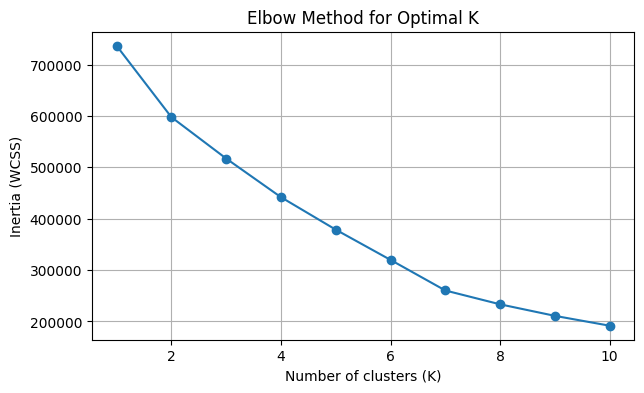


=== Cluster Summary (Mean) ===
               Total_depart_delay  Weather_delay  Air_system_delay  \
Delay_Cluster                                                        
0                         138.136         11.322            33.176   
1                           4.286          0.227             2.826   
2                          59.346          0.000            11.577   

               Late_aircraft_delay  Airline_delay  Security_delay  Depart_Hour  
Delay_Cluster                                                                   
0                           59.952         33.941           0.000       15.017  
1                            1.309          1.734           0.007       12.619  
2                            8.577          1.154          42.346       13.731  

=== Cluster Size ===
Delay_Cluster
0     6240
1    98978
2       26
Name: count, dtype: int64


In [87]:
cluster_cols = [
    "Total_depart_delay", "Weather_delay", "Air_system_delay",
    "Late_aircraft_delay", "Airline_delay", "Security_delay", "Depart_Hour"
]

missing = [c for c in cluster_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns in df: {missing}")

X_cluster = df[cluster_cols].copy().fillna(0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

K_range = range(1, 11)
inertias = []

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(7, 4))
plt.plot(list(K_range), inertias, marker="o")
plt.xlabel("Number of clusters (K)")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Method for Optimal K")
plt.grid(True)
plt.show()

K_CHOSEN = 3
kmeans = KMeans(n_clusters=K_CHOSEN, random_state=42, n_init=10)
df = df.copy()  
df["Delay_Cluster"] = kmeans.fit_predict(X_scaled)

cluster_summary = df.groupby("Delay_Cluster")[cluster_cols].mean().round(3)
print("\n=== Cluster Summary (Mean) ===")
print(cluster_summary)

cluster_size = df["Delay_Cluster"].value_counts().sort_index()
print("\n=== Cluster Size ===")
print(cluster_size)

clustered_path = OUT_DIR / "DDS_Flight_Delay_Clustered.csv"
df.to_csv(clustered_path, index=False)

summary_path = OUT_DIR / "DDS_Flight_Delay_Cluster_Summary.csv"
cluster_summary.to_csv(summary_path)

### **Phân tích chi tiết kết quả phân cụm K-Means (K = 3)**

**Cluster 1 – Nhóm không trễ hoặc trễ rất nhẹ**

- Số chuyến bay: 98.978
- Total_depart_delay ≈ 4.3 phút
- Các loại delay (thời tiết, hệ thống, hãng bay, an ninh) đều rất thấp, gần bằng 0
- Giờ khởi hành trung bình ≈ 12.6 giờ
- Mức trễ trung bình ~4 phút là không đáng kể trong vận hành hàng không.
- Việc các thành phần delay đều thấp cho thấy không có sự cố rõ ràng nào xảy ra.

> Cluster 1 đại diện cho các chuyến bay hoạt động bình thường, đúng giờ hoặc chỉ trễ rất nhẹ do yếu tố vận hành nhỏ. Đây là cluster có kích thước lớn nhất, chiếm phần lớn dữ liệu.

**Cluster 0 – Nhóm trễ nặng do nhiều nguyên nhân cộng dồn**

- Số chuyến bay: 6.240
- Total_depart_delay ≈ 138 phút (hơn 2 giờ)
- Late_aircraft_delay ≈ 60 phút
- Airline_delay ≈ 34 phút
- Air_system_delay ≈ 33 phút
- Weather_delay ≈ 11 phút
- Giờ khởi hành trung bình ≈ 15.0 giờ

Tổng thời gian trễ rất cao cho thấy đây không phải các trường hợp trễ thông thường.
Trễ không xuất phát từ một nguyên nhân duy nhất, mà là nhiều yếu tố xảy ra đồng thời.
Việc máy bay đến muộn (late aircraft) chiếm tỷ trọng lớn cho thấy hiệu ứng dây chuyền trong lịch bay.

> Cluster 0 đại diện cho các chuyến bay **trễ nghiêm trọng**, thường do nhiều sự cố vận hành và kỹ thuật xảy ra cùng lúc, gây ảnh hưởng lớn đến lịch trình bay và hành khách. 

**Cluster 2 – Nhóm trễ đặc biệt do an ninh**

- Số chuyến bay: 26
- Total_depart_delay ≈ 59 phút
- Security_delay ≈ 42 phút
- Các nguyên nhân trễ khác gần như bằng 0
- Giờ khởi hành trung bình ≈ 13.7 giờ

Phần lớn thời gian trễ đến từ ecurity delay, trong khi các yếu tố khác không đáng kể.
Số lượng chuyến bay trong cluster này rất nhỏ (rất hiếm gặp).
Điều này cho thấy các chuyến bay này mang tính ngoại lệ, không phản ánh hành vi chung của dữ liệu.

> Cluster 2 đại diện cho các trường hợp trễ đặc biệt liên quan đến an ninh, mang tính hiếm và được xem là outlier trong dữ liệu. Chiếm tỷ lệ rất nhỏ trong toàn bộ dữ liệu.

## Kết luận
- Mô hình phân loại dự đoán chuyến bay trễ đạt độ chính xác cao
- Confusion matrix cho thấy đa số chuyến bay được dự đoán đúng
- Regression ước lượng được số phút trễ
- Clustering giúp phân nhóm hành vi trễ để phân tích bổ trợ